<i>STATUS: Draft<i>

In [267]:
import numpy as np
import sympy as sp
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.patches import Rectangle
from IPython.display import Image
import sys


In the last notebook, we finished getting a basic handle on SDRs. We are now ready to start using htm.core a little, and also I will take the opportunity to clean up functions that I have created. 

We have some funtions that are to create SDRs, create noise. Let's first group the functions, to clean up mostly around making the visualisation, to pass SDRs of any size and getting coordinates. From here will start to build out a code base but also show along the way how we can use something more sophisticated. It seems a right of passage in HTM to build your own implementation, so we will use code for that, but htm.core will be what you want for production.

I will also start to look at various functions in the htm.core so we can use similiar types of language as we build things. 

Everything here is quite similiar, I made the visualise function more general 

In [508]:
#################### SINGLE SDR FUNCTIONS ###################################################


def create_randomised_sdr(capacity, population):
    sdr = set()
    while len(sdr) < population:
        sdr.add(np.random.randint(low=1, high=capacity))

    return(list(sdr))


def randomly_flip_percentage_of_bits(SDR, array_size, percentage_to_flip):
    to_remove = int(percentage_to_flip * len(SDR))
    randomised_SDR = np.random.shuffle(SDR)
    del SDR[0:to_remove]
    noise = create_randominsed_sdr(np.sqrt(array_size), np.sqrt(array_size), to_remove)
    sdr_with_noise = noise + SDR
    return(sdr_with_noise)



############## MULTIPLE SDR FUNCTIONS ###################################################
def compute_union_and_overlap(SDR1_on_bits, SDR2_on_bits):
    union = list(set(SDR1_on_bits).union(SDR2_on_bits))
    overlap = list(set(SDR1_on_bits).intersection(SDR2_on_bits))
    
    return({"union": union, "overlap": overlap})

def create_and_compare_sdrs_over_multiple_iterations(iterations, sdr_size, population):
    sdr_unions_for_comparison = []
    sdr_overlaps_for_comparison = []
    for x in range(iterations):
        SDR1 = create_randominsed_sdr(sdr_size, population)
        SDR2 =create_randominsed_sdr(sdr_size, population)
        sdr_comparison = compute_union_and_overlap(SDR1, SDR2)
        sdr_unions_for_comparison.append(len(sdr_comparison['union']))
        sdr_overlaps_for_comparison.append(len(sdr_comparison['overlap']))
    print("Average union: ", str(sum(sdr_unions_for_comparison) / len(sdr_unions_for_comparison)))
    print("Average overlap: ", str(sum(sdr_overlaps_for_comparison) / len(sdr_overlaps_for_comparison)))
    return({"union_comparison": sdr_unions_for_comparison, "overlap_comparison": sdr_overlaps_for_comparison})

def compute_overlap_set_cardinality(n, w0, w1, b, provide_summary = True):
    on_bit_space = sp.binomial(w0, b)
    off_bit_space = sp.binomial(n - w0, w1 - b)
    overlap_set = on_bit_space * off_bit_space
    if provide_summary:
        print("Given a capcity of", str(w0), "bits in the on-bit space, the number of ways to arrange ", str(b), "on-bits: ", on_bit_space)
        print("Given a capacity", str(n - w0), "bits in the off-bit space, the number of ways to arrange", str(w1 - b), "off-bits: ", off_bit_space)
        print("Number of SDRs that will match w0: ", overlap_set)
    return(overlap_set)

######################## VISUALISATION FUNCTIONS ############################################


def create_axis_for_sdr(ax, x_limit, y_limit, population, label, create_label = True):
    
    if create_label:
        label_add = np.round((population / (x_limit * y_limit)) * 100, 2)
        label = label + ' (Sparsity: {}%)'.format(label_add)
        ax.set_xlabel(label)
        
    ax.set_xticks(range(int(x_limit)))
    ax.set_yticks(range(int(y_limit)))
    [ax.xaxis.get_major_ticks()[i].tick1line.set_color("white") for i in range(int(x_limit))]
    [ax.yaxis.get_major_ticks()[i].tick1line.set_color("white") for i in range(int(y_limit))]
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.grid(color='k', linestyle='-', linewidth=.5)
    
    return(ax)


def convert_sdr_to_tuple_for_visualisation(sdr, sdr_size):
    
    counting_offset = 1
    # create array of complete sdrs

    m = np.zeros(sdr_size)
    for i in sdr:
        m[i] = m[i] + 1
    
    # find dimensions of visualisation
    n = sp.symbols('n')
    e = sp.Eq(2**n, sdr_size)
    s = sp.solve(e, n)
    middle_index = np.floor(float(s[0] / 2))
    
    if s[0] % 2 == 0:
        dimensions = [2**middle_index, 2**middle_index]
    else:
        dimensions = [2**middle_index, 2**(middle_index + 1)]
    
    d = np.reshape(m, [int(v) for v in dimensions])
    
    v = np.where(d == 1)

    
    coords = [(v[1][i], (dimensions[1] - counting_offset) - v[0][i]) for i in range(len(v[1]))]
    

    
    return(coords)


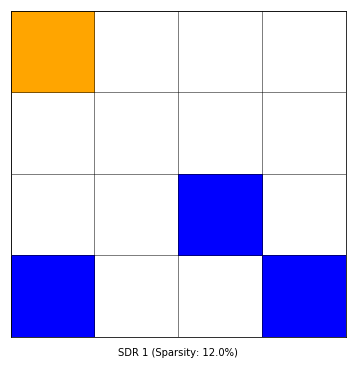

In [509]:
sdr_size = 16
population = 3
#label = str(np.round(sdr_size/population, 3))

specs1 = create_randomised_sdr(sdr_size, population)


fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))

ax1 = create_axis_for_sdr(ax1, np.sqrt(sdr_size) + 1, np.sqrt(sdr_size) + 1, population, "SDR 1")

coords = convert_sdr_to_tuple_for_visualisation(specs1, sdr_size)


SDR1 = [ax1.add_patch(Rectangle(coords[i], 1, 1, color="blue")) for i in range(len(specs1))]
SDR1 = ax1.add_patch(Rectangle([0,3], 1, 1, color="orange")) 

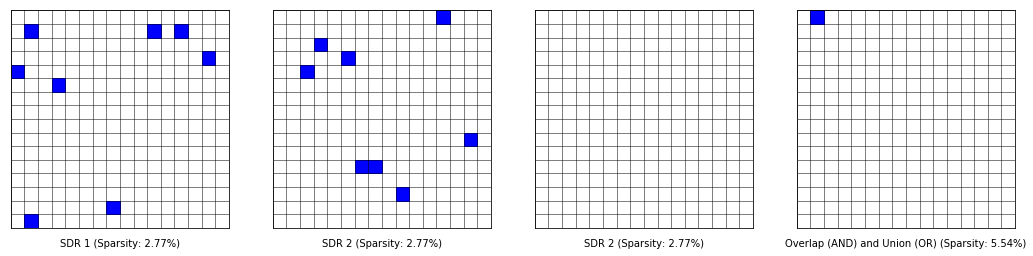

In [510]:
sdr_size = 256
population = 8
#label = str(np.round(sdr_size/population, 3))

specs1 = create_randomised_sdr(sdr_size, population)
specs2 = create_randomised_sdr(sdr_size, population)

x_vals, y_vals = sdr_comparison = compute_union_and_overlap(specs1, specs2)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 4))

ax1 = create_axis_for_sdr(ax1, np.sqrt(sdr_size) + 1, np.sqrt(sdr_size) + 1, population, "SDR 1")
ax2 = create_axis_for_sdr(ax2, np.sqrt(sdr_size) + 1, np.sqrt(sdr_size) + 1, population, "SDR 2")
ax3 = create_axis_for_sdr(ax3, np.sqrt(sdr_size) + 1, np.sqrt(sdr_size) + 1, population, "SDR 2")
ax4 = create_axis_for_sdr(ax4, np.sqrt(sdr_size) + 1, np.sqrt(sdr_size) + 1, len(sdr_comparison['union']), "Overlap (AND) and Union (OR)")


SDR1 = [ax1.add_patch(Rectangle(convert_sdr_to_tuple_for_visualisation(specs1, sdr_size)[i], 1, 1, color="blue")) for i in range(len(vis))]
SDR2 = [ax2.add_patch(Rectangle(convert_sdr_to_tuple_for_visualisation(specs2, sdr_size)[i], 1, 1, color="blue")) for i in range(len(specs2))]
SDR3 = ax4.add_patch(Rectangle([1,15], 1, 1, color="blue"))
#union = [ax3.add_patch(Rectangle(sdr_comparison['union'][i], 1, 1, color="gray")) for i in range(len(sdr_comparison['union']))]
# overlap = [ax3.add_patch(Rectangle(sdr_comparison['overlap'][i], 1, 1, color="orange")) for i in range(len(sdr_comparison['overlap']))]


Looks like things still work. Now let's move on to the idea of an encoder. THer is a videa for this which is very handy, we know that SDRs are a powerful way to get data, but how do take data that we experience in the real world and put it into this format. Start with the HTM shcool video: 

In [511]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/V3Yqtpytif0" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

At this point to we are going to start uisng the BAMI resource found at: [HERE]

1. Semantically similar data should result in SDRs with overlapping active bits.

2. The same input should always produce the same SDR as output.

3. The output should have the same dimensionality (total number of bits) for all inputs.

4. The output should have similar sparsity for all inputs and have enough one-bits to handle noise and
    subsampling.
    

<b>Semantically similar data should result in SDRs with overlapping active bits.</b><br/>

To create an effective encoder, you must understand the aspects of your data that should contribute to similarity. In the cochlea example above, the encoder was designed to make sounds with similar pitch have similar representations but did not take into account how loud the sounds were, which would require a different approach.

The first step to designing an encoder is to determine each of the aspects of the data that you want to capture. For sound, the key features may be pitch and amplitude; for dates, it may be whether or not it is a weekend.

The encoder should create representations that overlap for inputs that are similar in one or more of the characteristics of the data that were chosen. So for weekend encoders, dates that fall on Saturdays and Sundays should overlap with each other, but not as much or at all with dates that fall on weekdays.

<b>The same input should always produce the same SDR as output</b><br/>

Encoders should be deterministic so that the same input produces the same output every time. Without this property, the sequences learned in an HTM system will become obsolete as the encoded representations for values change. Avoid creating encoders with random or adaptive elements.
It can be tempting to create adaptive encoders that adjust representations to handle input data with an unknown range. There is a way to design an encoder to handle this case without changing the representations of inputs that is described below in the section labeled “A more flexible encoder method.” This method allows encoders to handle input with unbounded or unknown ranges.


<b>The output should have the same dimensionality (total number of bits) for all inputs</b><br/>

The output of an encoder must always produce the same number of bits for each of its inputs. SDRs are compared and operated on using a bit-by-bit assumption such that a bit with a certain “meaning” is always in the same position. If the encoders produced varying bit lengths for the SDRs, comparisons and other operations would not be possible.

<b>The output should have similar sparsity for all inputs and have enough one-bits to handle noise and subsampling</b><br/>

The fraction of total ON bits in an encoder can vary from around 1% to 35%, but the sparsity should be relatively fixed for a given application of an encoder. While keeping the sparsity the same should be the rule, small variations in sparsity will not have a negative effect.
Additionally, there must be enough one-bits to handle noise and subsampling. A general rule of thumb is to have at least 20-25 one bits. Encoders that produce representations with fewer than 20 one bits do not work well in HTM systems since they may become extremely susceptible to errors due to small amounts of noise or non-determinism.

Let's build an encorder and start with numbers, numbers are bit overly simple. For an input space a grid like above, how many buckets can 


In [512]:
def compute_bucket_capacity(n, w):
    bucket_capacity = n - w + 1
    
    return(bucket_capacity)

An intuitive way to think about this is is 400 bits in my outputs space. If i have a bucket size of 1 how many bits can this encode? If I wanted each integer represetned

In [513]:
compute_bucket_capacity(400, 1)

400

Alternatively, what if I wanted every integer represented  with a number of of bits: 

In [516]:
class CreateEncoder:
    def __init__(self, bit_space_size = 64,
                number_of_bits_per_value = 5,
                min_val = 0,
                max_val = 100):
        self.bit_space_size = bit_space_size
        self.number_of_bits_per_value = number_of_bits_per_value
        self.min_value_to_encode = min_val
        self.max_value_to_encode = max_val
        self.buckets = self.compute_bucket_capacity(self.bit_space_size, self.number_of_bits_per_value)
        self.offset = 1
        self.current_encoded_value = None
        self.previously_encoded_values = np.array([])
        self.is_periodic = False
    
    def compute_bucket_capacity(self, n, w):
        return(n - w + 1)
    
    def create_encoded_array(self):
        pass
    
    def get_location_of_value(self, v):
        if self.current_encoded_value is not None:
            self.previously_encoded_values = np.append(self.previously_encoded_values, self.current_encoded_value)
        
        self.current_encoded_value = v
        window = [self.current_encoded_value , self.current_encoded_value + self.number_of_bits_per_value - self.offset ]
        all_values = np.arange(window[0], window[1] + self.offset)
        return(all_values)
    
    def set_number_of_output_bits(self, n):
        pass
        
        
f = CreateEncoder()     

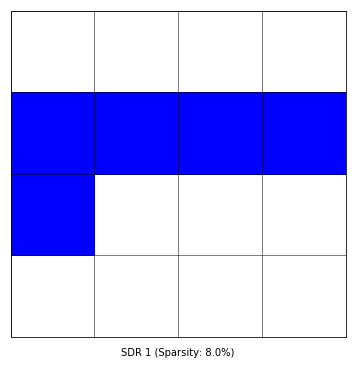

In [517]:

sdr_size = 16
population = 2

specs1 = f.get_location_of_value(4)


fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))

ax1 = create_axis_for_sdr(ax1, np.sqrt(sdr_size) + 1, np.sqrt(sdr_size) + 1, population, "SDR 1")

t = convert_sdr_to_tuple_for_visualisation(specs1, sdr_size)

SDR1 = [ax1.add_patch(Rectangle(convert_sdr_to_tuple_for_visualisation(specs1, sdr_size)[i], 1, 1, color="blue")) for i in range(len(specs1))]


In [401]:
f.get_location_of_value(22)

array([22, 23])

In [402]:
f.previously_encoded_values

array([ 9., 22.,  9.])

In [44]:
n = 12
w = 4
min_value = 0
max_value = 55

scaler_value_to_encode = 50

compare_periodic = False
use_periodic_encoder = False

# number of buckets - places to put stuff in
n - w

# should automatically 

# 1. create possible buckets
# 2. assign all values to buckets
# 3. look at comparison values, adjacent or not

8

58738.78125*pi